In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [27]:
td = pd.read_csv('/Users/leichen/Desktop/toydata.csv', header=0, index_col=0)
td.index = pd.to_datetime(td.index)

In [29]:
def create_lag(data, cov,lag):
    for i in range(1, lag+1):
        data[f'lag_{i}'] = data.groupby(cov)['Consumption'].shift(i)
    return data

td = create_lag(td, 'Location',1)
td = create_lag(td, 'Location',2)
# td = create_lag(td, 'Location',3)
td.dropna(inplace=True)

In [30]:
td_A = td[td['Location']=='A']
train_size = int(len(td_A)*0.8)
split_date = td_A.iloc[:train_size].index[-1]
train_A = td_A.loc[td_A.index <= split_date]
test_A = td_A.loc[td_A.index > split_date]
td_B = td[td['Location']=='B']
train_B = td_B.loc[td_B.index <= split_date]
test_B = td_B.loc[td_B.index > split_date]

In [31]:
def create_features(df):
    """
    Create time-based features such as hour of the day, day of the week, etc.
    """
    df.index = pd.to_datetime(df.index)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week
    return df


df_A = create_features(td_A)
df_B = create_features(td_B)

/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

# Location A

In [13]:
train_A = create_features(train_A)
test_A = create_features(test_A)

features = ['month', 'quarter', 'weekofyear','lag_1','lag_2']
target = 'Consumption'

X_trainA = train_A[features]
y_trainA = train_A[target]

X_testA = test_A[features]
y_testA = test_A[target]

reg = xgb.XGBRegressor(base_score=0.5,booster = 'gbtree',n_estimators=1000, early_stopping_rounds=50, max_depth=3, learning_rate=0.01, objective='reg:linear')
reg.fit(X_trainA, y_trainA, eval_set=[(X_trainA, y_trainA), (X_testA, y_testA)], verbose=100)

[0]	validation_0-rmse:0.14611	validation_1-rmse:0.19416
[100]	validation_0-rmse:0.07843	validation_1-rmse:0.13592


/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[200]	validation_0-rmse:0.04931	validation_1-rmse:0.11639
[300]	validation_0-rmse:0.03408	validation_1-rmse:0.11254
[400]	validation_0-rmse:0.02484	validation_1-rmse:0.11006
[500]	validation_0-rmse:0.01847	validation_1-rmse:0.10829
[548]	validation_0-rmse:0.01606	validation_1-rmse:0.10857


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

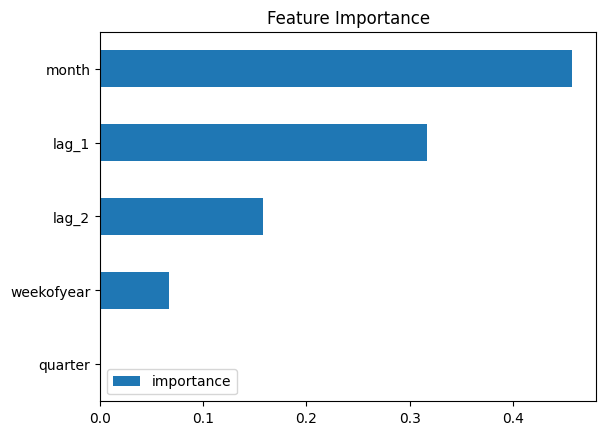

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [15]:
test_A['Consumption_pred'] = reg.predict(X_testA)
df_mA = df_A.merge(test_A[['Consumption_pred']], how='left', left_index=True, right_index=True)

/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/802638830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_A['Consumption_pred'] = reg.predict(X_testA)


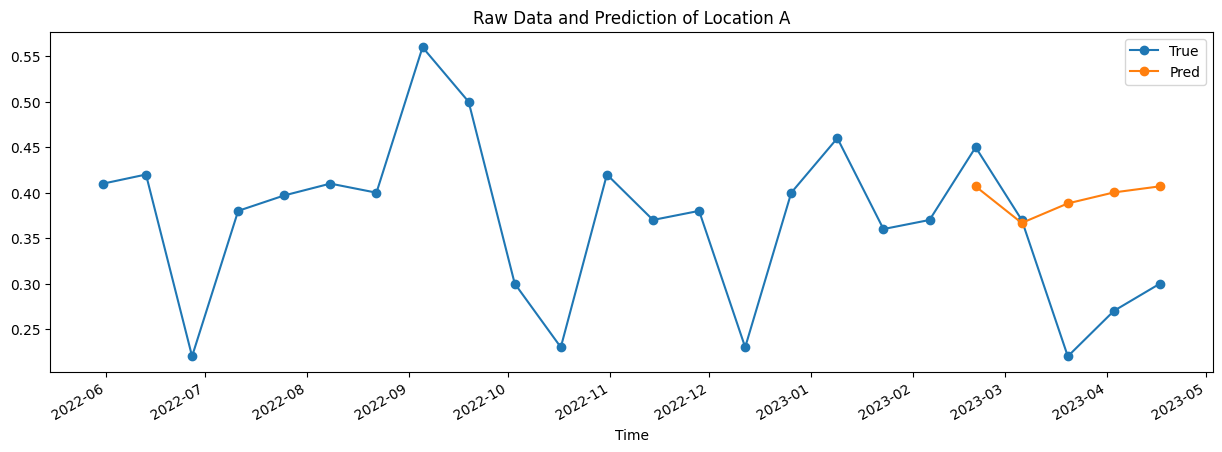

In [16]:
df_A= df_mA[df_mA['Location']=='A']
ax =df_A['Consumption'] .plot(figsize=(15,5),style='o-')
df_A['Consumption_pred'].plot(ax=ax, style='o-')
plt.legend(['True', 'Pred'])
ax.set_title('Raw Data and Prediction of Location A')
plt.show()

In [17]:
score = np.sqrt(mean_squared_error(test_A['Consumption'], test_A['Consumption_pred']))
print(f'RMSE Score on Test set: {score:0.2f}')
print(test_A[['Location','Consumption', 'Consumption_pred']])

RMSE Score on Test set: 0.11
           Location  Consumption  Consumption_pred
Time                                              
2023-02-20        A         0.45          0.406897
2023-03-06        A         0.37          0.366717
2023-03-20        A         0.22          0.388222
2023-04-03        A         0.27          0.400304
2023-04-17        A         0.30          0.407009


# Location B

In [22]:
train_B = create_features(train_B)
test_B = create_features(test_B)

features = ['month', 'quarter', 'weekofyear','lag_1','lag_2']
target = 'Consumption'

X_trainB = train_B[features]
y_trainB = train_B[target]

X_testB = test_B[features]
y_testB = test_B[target]

reg = xgb.XGBRegressor(base_score=0.5,booster = 'gbtree',n_estimators=1000, early_stopping_rounds=50, max_depth=3, learning_rate=0.01, objective='reg:linear')
reg.fit(X_trainB, y_trainB, eval_set=[(X_trainB, y_trainB), (X_testB, y_testB)], verbose=100)

[0]	validation_0-rmse:0.20378	validation_1-rmse:0.14171
[100]	validation_0-rmse:0.12042	validation_1-rmse:0.07037


/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['quarter'] = df.index.quarter
/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df.index.month
/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/2654883959.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

[164]	validation_0-rmse:0.09509	validation_1-rmse:0.07502


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

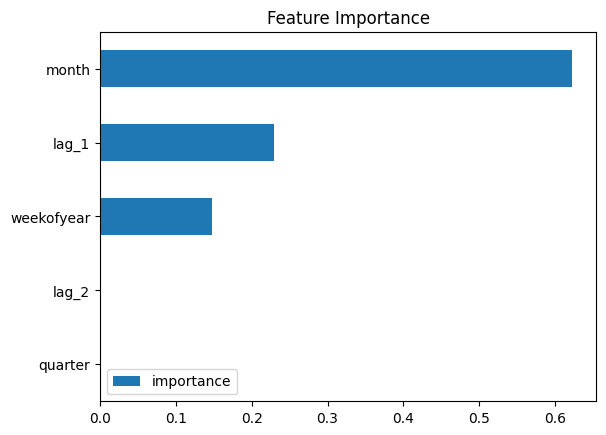

In [23]:
fi = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

/var/folders/gx/rgnxtx6n5td6bqx9y9z8745h0000gn/T/ipykernel_41168/3971376036.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_B['Consumption_pred'] = reg.predict(X_testB)


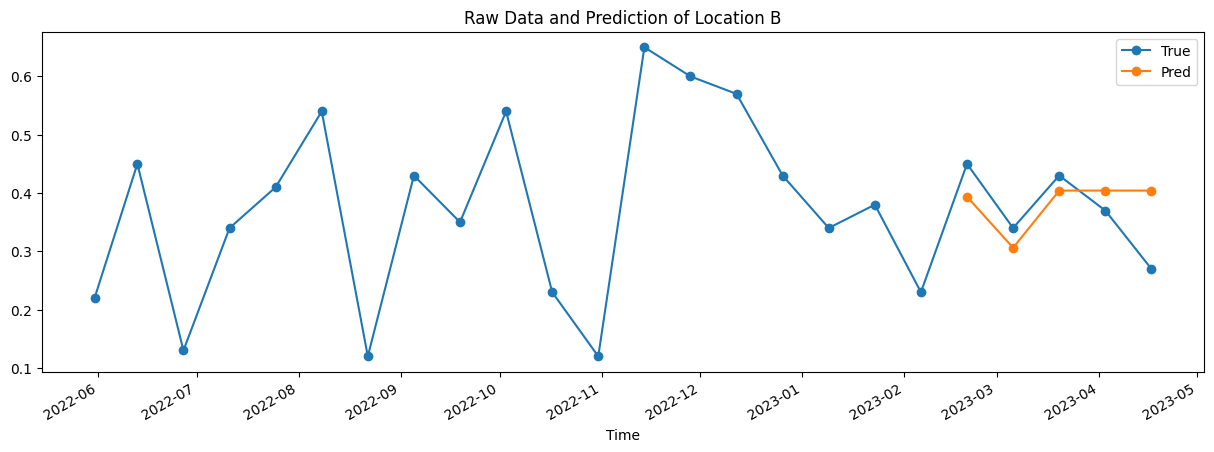

In [24]:
test_B['Consumption_pred'] = reg.predict(X_testB)
df_mB = df_B.merge(test_B[['Consumption_pred']], how='left', left_index=True, right_index=True)
df_B= df_mB[df_mB['Location']=='B']
ax =df_B['Consumption'] .plot(figsize=(15,5),style='o-')
df_B['Consumption_pred'].plot(ax=ax, style='o-')
plt.legend(['True', 'Pred'])
ax.set_title('Raw Data and Prediction of Location B')
plt.show()

In [25]:
score = np.sqrt(mean_squared_error(test_B['Consumption'], test_B['Consumption_pred']))
print(f'RMSE Score on Test set: {score:0.2f}')
print(test_B[['Location','Consumption', 'Consumption_pred']])

RMSE Score on Test set: 0.07
           Location  Consumption  Consumption_pred
Time                                              
2023-02-20        B         0.45          0.393665
2023-03-06        B         0.34          0.306165
2023-03-20        B         0.43          0.404211
2023-04-03        B         0.37          0.404211
2023-04-17        B         0.27          0.404211


In [35]:
td

,Consumption,Location,Dis,lag_1,lag_2
Time,,,,,
2022-06-27,0.220,A,150,0.420,0.410
2022-07-11,0.380,A,150,0.220,0.420
2022-07-25,0.397,A,150,0.380,0.220
2022-08-08,0.410,A,150,0.397,0.380
2022-08-22,0.400,A,150,0.410,0.397
2022-09-05,0.560,A,150,0.400,0.410
2022-09-19,0.500,A,150,0.560,0.400
2022-10-03,0.300,A,150,0.500,0.560
2022-10-17,0.230,A,150,0.300,0.500


In [42]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

td_1 = td.loc[td['Location']=='A','Consumption']

In [43]:
def add_gaussian_noise(time_series, mean=0.0, stddev=1.0):
    """
    Adds Gaussian noise to a time series.

     Options:
     time_series (array-like): A time series to which noise is added.
     mean (float): The average value of the noise. Default is 0.0.
     stddev (float): Standard deviation of noise. Default is 1.0.

     Returns:
     noisy_series (np.array): Time series with added noise.
     """
     # Gaussian noise generation
    noise = np.random.normal(mean, stddev, len(time_series))

    # Adding noise to the original time series
    noisy_series = time_series + noise

    return noisy_series

augmented_time_series_data = add_gaussian_noise(td_1, mean=0.0, stddev=0.05)

In [44]:
augmented_time_series_data 

Time
2022-06-27    0.239076
2022-07-11    0.373931
2022-07-25    0.371954
2022-08-08    0.455398
2022-08-22    0.399261
2022-09-05    0.559536
2022-09-19    0.469862
2022-10-03    0.320223
2022-10-17    0.228795
2022-10-31    0.317903
2022-11-14    0.368581
2022-11-28    0.435603
2022-12-12    0.292191
2022-12-26    0.310948
2023-01-09    0.518707
2023-01-23    0.368654
2023-02-06    0.302234
2023-02-20    0.452455
2023-03-06    0.400776
2023-03-20    0.185896
2023-04-03    0.336049
2023-04-17    0.279939
Name: Consumption, dtype: float64